In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

# Open SOS slow data

In [2]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone( sos_df, 'UTC', 'US/Mountain')

## Plot wind directions for case studies

In [3]:
def wind_chart(data):
    return alt.Chart(data).mark_line().encode(        
        alt.X('time:T'),
        alt.Y('value:Q'),
        alt.Color('height:O').scale(scheme='rainbow')
    ).properties(height=150)
def vertical_lines_chart(data):
    return alt.Chart(
        data
    ).mark_rule(color='red', strokeDash=[4, 2]).encode(
        alt.X('time:T')
    )


sos_dir_df = sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time')

(
    (wind_chart(sos_dir_df.loc['20230409'].reset_index())   + vertical_lines_chart(pd.DataFrame({'time': ['2023-04-09T15:00:00', '2023-04-09T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20230418'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2023-04-18T15:00:00', '2023-04-18T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20221221'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2022-12-21T15:00:00', '2022-12-21T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20230304'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2023-03-04T15:00:00', '2023-03-04T18:00:00']})))
)

alt.HConcatChart(...)

In [4]:
sos_dir_df.sort_index().loc['20230418 1900': '20230418 2200'].query("variable == 'dir_3m_c'").value.mean()

158.2565144130162

# Open SOS fast data

In [5]:
apr18_df = fast_data_files_to_dataframe([
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_21.nc',
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_22.nc',
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_23.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_01.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_02.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_03.nc',
],  rotation='double')

apr18_df = utils.modify_df_timezone(apr18_df, pytz.UTC, "US/Mountain")

-159.63829
mean u, v, w after first rotation  u_2m_c    9.646917e-01
v_2m_c   -5.877460e-08
w_2m_c    1.328826e-02
dtype: float32
-160.61166
mean u, v, w after first rotation  u_3m_c    9.707044e-01
v_3m_c   -3.616898e-08
w_3m_c    1.209827e-02
dtype: float32
-161.35495
mean u, v, w after first rotation  u_5m_c    9.683220e-01
v_5m_c   -4.521123e-08
w_5m_c   -8.051571e-03
dtype: float32
-166.3347
mean u, v, w after first rotation  u_10m_c    8.814763e-01
v_10m_c   -1.311126e-07
w_10m_c   -5.393248e-02
dtype: float32
-164.43513
mean u, v, w after first rotation  u_15m_c    7.411802e-01
v_15m_c   -1.582393e-07
w_15m_c   -4.498928e-02
dtype: float32
-162.94327
mean u, v, w after first rotation  u_20m_c    7.486337e-01
v_20m_c    1.808449e-08
w_20m_c   -1.044777e-01
dtype: float32
-153.52493
mean u, v, w after first rotation  u_3m_uw    1.042306e+00
v_3m_uw    4.069010e-08
w_3m_uw    2.311073e-02
dtype: float32
-153.95428
mean u, v, w after first rotation  u_10m_uw    9.413269e-01
v_10m_uw

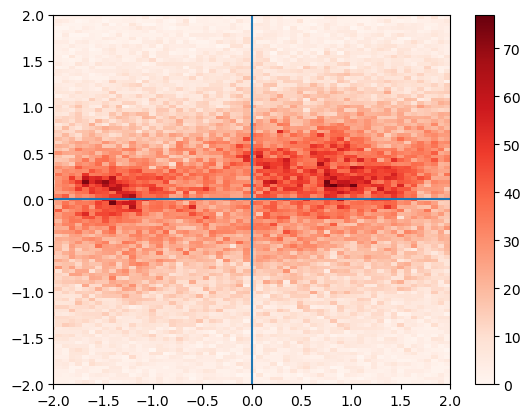

In [6]:
src = apr18_df.set_index('time')[['u_10m_c', 'w_10m_c']]
src_fluc = src - src.groupby(pd.Grouper(freq='30min')).transform('mean')
plt.hist2d(src_fluc.u_10m_c, src_fluc.w_10m_c, bins=500, cmap='Reds')
plt.axhline(0)
plt.axvline(0)
plt.colorbar()
plt.xlim(-2,2); plt.ylim(-2,2)
plt.show()

# Spectra across two case study days - Apr 18 and Dec 21

## Apr 18

### u'w' cospectra - all ECs

In [7]:
apr18_u_w_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'w_3m_c', shift = 2000, parallelism=8)
apr18_u_w_3m_d_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_d', 'w_3m_d', shift = 2000, parallelism=8)
apr18_u_w_3m_ue_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_ue', 'w_3m_ue', shift = 2000, parallelism=8)
apr18_u_w_3m_uw_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_uw', 'w_3m_uw', shift = 2000, parallelism=8)

apr18_u_w_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_c', 'w_10m_c', shift = 2000, parallelism=8)
apr18_u_w_10m_d_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_d', 'w_10m_d', shift = 2000, parallelism=8)
apr18_u_w_10m_ue_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_ue', 'w_10m_ue', shift = 2000, parallelism=8)
apr18_u_w_10m_uw_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_uw', 'w_10m_uw', shift = 2000, parallelism=8)

apr18_u_w_5m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_5m_c', 'w_5m_c', shift = 2000, parallelism=8)
apr18_u_w_15m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_15m_c', 'w_15m_c', shift = 2000, parallelism=8)
apr18_u_w_20m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_20m_c', 'w_20m_c', shift = 2000, parallelism=8)

Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:18<00:00,  2.21it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.95it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:16<00:00,  2.50it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:16<00:00,  2.48it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:16<00:00,  2.59it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.80it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.83it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:15<00:00,  2.76it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [1:24:31<00:00, 120.76s/it]  


In [8]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
)
def mrd_plot(data, title=''):
    return alt.layer(
        base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q')),
        base.mark_line().encode(alt.Y('mean(Co):Q')),
        data=data
    ).properties(width=200, height=200, title=title)

In [9]:
(
    (
        mrd_plot(apr18_u_w_3m_c_mrd_df, "u'w', 3m-C") | mrd_plot(apr18_u_w_3m_d_mrd_df, "u'w', 3m-D") 
        | mrd_plot(apr18_u_w_3m_ue_mrd_df, "u'w', 3m-UE") | mrd_plot(apr18_u_w_3m_uw_mrd_df, "u'w', 3m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(apr18_u_w_10m_c_mrd_df, "u'w', 10m-C") | mrd_plot(apr18_u_w_10m_d_mrd_df, "u'w', 10m-D") 
        | mrd_plot(apr18_u_w_10m_ue_mrd_df, "u'w', 10m-UE") | mrd_plot(apr18_u_w_10m_uw_mrd_df, "u'w', 10m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(apr18_u_w_5m_c_mrd_df, "u'w', 5m-C") |  mrd_plot(apr18_u_w_15m_c_mrd_df, "u'w', 15m-C") |  mrd_plot(apr18_u_w_20m_c_mrd_df, "u'w', 20m-C")
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

alt.VConcatChart(...)

### Isotropic stress cospectra - tower c 3 and 10m

In [10]:
apr18_u_u_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'u_3m_c', shift = 2000, parallelism=8)
apr18_v_v_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'v_3m_c', 'v_3m_c', shift = 2000, parallelism=8)
apr18_w_w_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'w_3m_c', 'w_3m_c', shift = 2000, parallelism=8)

apr18_u_u_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_c', 'u_10m_c', shift = 2000, parallelism=8)
apr18_v_v_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'v_10m_c', 'v_10m_c', shift = 2000, parallelism=8)
apr18_w_w_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'w_10m_c', 'w_10m_c', shift = 2000, parallelism=8)

Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [01:52<00:00,  2.68s/it]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.92it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [03:50<00:00,  5.49s/it]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.90it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [26:10<00:00, 37.40s/it]


In [11]:
((
    mrd_plot(apr18_u_u_3m_c_mrd_df, "u'u', 3m-C") | mrd_plot(apr18_v_v_3m_c_mrd_df, "v'v', 3m-C") 
).resolve_scale(y='shared') & (
    mrd_plot(apr18_u_u_10m_c_mrd_df, "u'u', 10-C") | mrd_plot(apr18_v_v_10m_c_mrd_df, "v'v', 3m-C")
).resolve_scale(y='shared')).resolve_scale(y='shared') | (
    mrd_plot(apr18_w_w_3m_c_mrd_df, "w'w', 3m-C") & mrd_plot(apr18_w_w_10m_c_mrd_df, "w'w', 10m-C")
).resolve_scale(y='shared')

alt.HConcatChart(...)

## Dec 21

In [12]:
dec21_df = fast_data_files_to_dataframe([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_23.nc',
],  rotation='double')
dec21_df = utils.modify_df_timezone(dec21_df, pytz.UTC, "US/Mountain")

-61.833385
mean u, v, w after first rotation  u_2m_c    5.325658e+00
v_2m_c   -4.837601e-07
w_2m_c    8.059380e-02
dtype: float32
-60.20123
mean u, v, w after first rotation  u_3m_c    5.669217e+00
v_3m_c    1.130281e-07
w_3m_c    5.993508e-02
dtype: float32
-62.363598
mean u, v, w after first rotation  u_5m_c    6.094958e+00
v_5m_c   -1.537182e-07
w_5m_c    6.208957e-02
dtype: float32
-60.802074
mean u, v, w after first rotation  u_10m_c    6.465034e+00
v_10m_c    5.470558e-07
w_10m_c   -6.427024e-03
dtype: float32
-62.69881
mean u, v, w after first rotation  u_15m_c    6.803667e+00
v_15m_c   -2.961335e-07
w_15m_c    5.895937e-02
dtype: float32
-62.253933
mean u, v, w after first rotation  u_20m_c    7.077481e+00
v_20m_c   -2.215350e-07
w_20m_c    2.049043e-02
dtype: float32
-62.966145
mean u, v, w after first rotation  u_3m_uw    5.593379e+00
v_3m_uw   -5.900065e-07
w_3m_uw    1.943769e-02
dtype: float32
-61.361576
mean u, v, w after first rotation  u_10m_uw    6.501176e+00
v_10m_uw 

### u'w' cospectra - all ECs

In [13]:
dec21_u_w_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'w_3m_c', shift = 2000, parallelism=8)
dec21_u_w_3m_d_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_d', 'w_3m_d', shift = 2000, parallelism=8)
dec21_u_w_3m_ue_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_ue', 'w_3m_ue', shift = 2000, parallelism=8)
dec21_u_w_3m_uw_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_uw', 'w_3m_uw', shift = 2000, parallelism=8)

dec21_u_w_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_c', 'w_10m_c', shift = 2000, parallelism=8)
dec21_u_w_10m_d_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_d', 'w_10m_d', shift = 2000, parallelism=8)
dec21_u_w_10m_ue_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_ue', 'w_10m_ue', shift = 2000, parallelism=8)
dec21_u_w_10m_uw_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_uw', 'w_10m_uw', shift = 2000, parallelism=8)

dec21_u_w_5m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_5m_c', 'w_5m_c', shift = 2000, parallelism=8)
dec21_u_w_15m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_15m_c', 'w_15m_c', shift = 2000, parallelism=8)
dec21_u_w_20m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_20m_c', 'w_20m_c', shift = 2000, parallelism=8)

Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [02:40<00:00,  3.81s/it]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.92it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [57:15<00:00, 81.80s/it] 


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.89it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.90it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.92it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.83it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:41<00:00,  1.02it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [03:08<00:00,  4.48s/it]


In [14]:
def mrd_plot(data, title='', color=None):
    base = alt.Chart().encode(
        alt.X('tau:Q').scale(type='log').title('tau (s)'),
    )
    if color:
        band = base.mark_errorband(extent='iqr', color=color).encode(alt.Y('Co:Q'))
        line = base.mark_line(color=color).encode(alt.Y('mean(Co):Q'))
    else:
        band = base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q'))
        line = base.mark_line().encode(alt.Y('mean(Co):Q'))
    return alt.layer(
        band, line, data=data
    ).properties(width=200, height=200, title=title)

In [15]:
(
    (
        mrd_plot(dec21_u_w_3m_c_mrd_df, "u'w', 3m-C") | mrd_plot(dec21_u_w_3m_d_mrd_df, "u'w', 3m-D") 
        | mrd_plot(dec21_u_w_3m_ue_mrd_df, "u'w', 3m-UE") | mrd_plot(dec21_u_w_3m_uw_mrd_df, "u'w', 3m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(dec21_u_w_10m_c_mrd_df, "u'w', 10m-C") | mrd_plot(dec21_u_w_10m_d_mrd_df, "u'w', 10m-D") 
        | mrd_plot(dec21_u_w_10m_ue_mrd_df, "u'w', 10m-UE") | mrd_plot(dec21_u_w_10m_uw_mrd_df, "u'w', 10m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(dec21_u_w_5m_c_mrd_df, "u'w', 5m-C") |  mrd_plot(dec21_u_w_15m_c_mrd_df, "u'w', 15m-C") |  mrd_plot(dec21_u_w_20m_c_mrd_df, "u'w', 20m-C")
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

alt.VConcatChart(...)

In [16]:
(mrd_plot(dec21_u_w_3m_c_mrd_df, "u'w', 3m-C") + mrd_plot(apr18_u_w_3m_c_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_d_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_ue_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_uw_mrd_df, "u'w', 3m-C", color='#ff7f0e')) |\
(mrd_plot(dec21_u_w_10m_c_mrd_df, "u'w', 10m-C") + mrd_plot(apr18_u_w_10m_c_mrd_df, "u'w', 10m-C", color='#ff7f0e')) |\
(mrd_plot(dec21_u_w_5m_c_mrd_df, "u'w', 5m-C") + mrd_plot(apr18_u_w_5m_c_mrd_df, "u'w', 5m-C", color='#ff7f0e'))

alt.HConcatChart(...)

### Isotropic stress cospectra - tower c 3 and 10m

In [17]:
dec21_u_u_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'u_3m_c', shift = 2000, parallelism=8)
dec21_v_v_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'v_3m_c', 'v_3m_c', shift = 2000, parallelism=8)
dec21_w_w_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'w_3m_c', 'w_3m_c', shift = 2000, parallelism=8)

dec21_u_u_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_c', 'u_10m_c', shift = 2000, parallelism=8)
dec21_v_v_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'v_10m_c', 'v_10m_c', shift = 2000, parallelism=8)
dec21_w_w_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'w_10m_c', 'w_10m_c', shift = 2000, parallelism=8)

Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.92it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [08:52<00:00, 12.68s/it]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:14<00:00,  2.93it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [01:01<00:00,  1.47s/it]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:13<00:00,  3.07it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:13<00:00,  3.06it/s]


In [18]:
((
    mrd_plot(dec21_u_u_3m_c_mrd_df, "u'u', 3m-C") | mrd_plot(dec21_v_v_3m_c_mrd_df, "v'v', 3m-C") 
).resolve_scale(y='shared') & (
    mrd_plot(dec21_u_u_10m_c_mrd_df, "u'u', 10-C") | mrd_plot(dec21_v_v_10m_c_mrd_df, "v'v', 3m-C")
).resolve_scale(y='shared')).resolve_scale(y='shared') | (
    mrd_plot(dec21_w_w_3m_c_mrd_df, "w'w', 3m-C") & mrd_plot(dec21_w_w_10m_c_mrd_df, "w'w', 10m-C")
).resolve_scale(y='shared')

alt.HConcatChart(...)

# Spectra across two months of data

Open up all the nomrd files. Calculate a "median time" for joining with synoptic wind measurements

In [19]:
nomrd_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/NOmrds/")
nomrd_df['median_time'] = nomrd_df.start_time + 0.5*(nomrd_df.end_time - nomrd_df.start_time)
nomrd_df['median_time_rounded'] = nomrd_df.median_time.dt.round('30min')
nomrd_df

,tau,Co,std,iteration,start_time,end_time,covariance,loc,median_time,median_time_rounded
0,0.1,-0.002316,4.401546e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
1,0.2,-0.004666,4.751782e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
2,0.4,-0.007815,5.590110e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
3,0.8,-0.011504,6.878115e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
4,1.6,-0.011965,6.791920e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
...,...,...,...,...,...,...,...,...,...,...
12,409.6,0.000337,1.142486e-03,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00
13,819.2,0.001552,1.921631e-03,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00
14,1638.4,0.000481,4.260532e-04,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00
15,3276.8,-0.000060,7.827031e-06,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00


Remove the Dec 21 MRD

In [20]:
nomrd_df = nomrd_df[nomrd_df.start_time.dt.month != 12]

In [21]:
nomrd_df.start_time.dt.hour.min(), nomrd_df.start_time.dt.hour.max()

(8, 16)

Use doppler lidar data to identify along-valley/cross-valley synoptic flows

In [22]:
cross_valley_wind_times = pd.read_csv('cross_valley_wind_times.csv').drop(columns='Unnamed: 0').rename(columns={'0':'time'}).set_index('time').assign(
    wind_dir='cross-valley'
)
cross_valley_wind_times.index = pd.to_datetime(cross_valley_wind_times.index)

along_valley_wind_times = pd.read_csv('along_valley_wind_times.csv').drop(columns='Unnamed: 0').rename(columns={'0':'time'}).set_index('time').assign(
    wind_dir='along-valley'
)
along_valley_wind_times.index = pd.to_datetime(along_valley_wind_times.index)

winds_ge10_times =      pd.read_csv('winds_ge10_times.csv').drop(columns='Unnamed: 0').set_index('time').assign(wind_speed='> 10')
winds_ge10_times.index = pd.to_datetime(winds_ge10_times.index)
winds_le10_times =      pd.read_csv('winds_le10_times.csv').drop(columns='Unnamed: 0').set_index('time').assign(wind_speed='<= 10')
winds_le10_times.index = pd.to_datetime(winds_le10_times.index)

Join the datasets

In [23]:
nomrd_df_synopticwinds = pd.concat([
    nomrd_df.set_index('median_time_rounded').join(cross_valley_wind_times, how='inner'),
    nomrd_df.set_index('median_time_rounded').join(along_valley_wind_times, how='inner')
])
nomrd_df_synopticwinds = nomrd_df_synopticwinds.join(pd.concat([ winds_le10_times, winds_ge10_times]), how='inner')

In [24]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Color('wind_dir:N'),
).properties(width=200, height=200, title = "u'w', 3m-c")

def layer_plot(data, title=''):
    return alt.layer(
        base.encode(alt.Y('Co:Q')).mark_errorband(extent='iqr'),
        base.encode(alt.Y('mean(Co):Q')).mark_line(),
        data = data
    ).facet(alt.Row('wind_speed')).properties(title=title)

In [25]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]
src['date'] = src.start_time.dt.date.astype('str')
alt.Chart(
    src.query("loc == '3m_c'")
).mark_line(strokeWidth=1, point={'size': 10}).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Detail('date'),
    alt.Color('wind_dir:N'),
    alt.Facet('wind_speed'),
    tooltip = 'date'
).properties(width=200, height=200)

alt.Chart(...)

In [26]:
4/18, 3/8, 4/2, 3/6

(0.2222222222222222, 0.375, 2.0, 0.5)

In [27]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c")
    &\
    layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c")
    &\
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c")
    &\
    layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c")
    &\
    layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")

) 

alt.VConcatChart(...)

In [28]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c") | layer_plot(src.query("loc == '3m_d'"), title="u'w' 3m_d") | layer_plot(src.query("loc == '3m_ue'"), title="u'w' 3m_ue") | layer_plot(src.query("loc == '3m_uw'"), title="u'w' 3m_uw")
) &\
layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c") &\
(
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c") | layer_plot(src.query("loc == '10m_d'"), title="u'w' 10m_d") | layer_plot(src.query("loc == '10m_ue'"), title="u'w' 10m_ue") | layer_plot(src.query("loc == '10m_uw'"), title="u'w' 10m_uw")
)  &\
layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c") &\
layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")

alt.VConcatChart(...)

In [29]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]
(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c") |\
    layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c") |\
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c")
) & (
    layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c") |\
    layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")
)

alt.VConcatChart(...)

In [30]:
src = nomrd_df_synopticwinds.query("covariance == 'v_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'")) | layer_plot(src.query("loc == '3m_d'")) | layer_plot(src.query("loc == '3m_ue'")) | layer_plot(src.query("loc == '3m_uw'"))
) &\
layer_plot(src.query("loc == '5m_c'")) &\
(
    layer_plot(src.query("loc == '10m_c'")) | layer_plot(src.query("loc == '10m_d'")) | layer_plot(src.query("loc == '10m_ue'")) | layer_plot(src.query("loc == '10m_uw'"))
)  &\
layer_plot(src.query("loc == '15m_c'")) &\
layer_plot(src.query("loc == '20m_c'"))

alt.VConcatChart(...)